<a href="https://colab.research.google.com/github/sripragnabitra/RecommendationSystems/blob/main/Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Recommendation Systems***

Machine learning-based recommendation systems are powerful engines using machine learning algorithms to segment customers based on user data and behavioral patterns (such as purchase and browsing history, likes, or reviews) and target them with personalized product or content suggestions.

Recommendation systems are among the most popular applications of data science. They are used to predict the Rating or Preference that a user would give to an item. The model created recommends books based on 4 types: Most popular books, books based on Collaborative Filtering, K Nearest Neighbours(kNN) and Content-Based Filtering.

In [ ]:
#import necessary libraries
import re
import pickle
import operator
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from scipy.sparse import csr_matrix
from pandas.api.types import is_numeric_dtype
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings("ignore")

Importing data from kaggle dataset stored in github repository

In [ ]:
#import data
books = pd.read_csv("BX_Books.csv", delimiter=';', error_bad_lines=False, engine="python", encoding='ISO-8859-1', warn_bad_lines=False)
users = pd.read_csv("BX-Users.csv", sep=';', error_bad_lines=False, encoding='ISO-8859-1', warn_bad_lines=False)
ratings = pd.read_csv("BX-Book-Ratings.csv", sep=';', error_bad_lines=False, engine="python", encoding='ISO-8859-1', warn_bad_lines=False)

print("Books Data:    ", books.shape)
print("Users Data:    ", users.shape)
print("Books-ratings: ", ratings.shape)
print(list(books.columns))
print(list(users.columns))
print(list(ratings.columns))

Books Data:     (270494, 8)
Users Data:     (278858, 3)
Books-ratings:  (1149766, 3)
['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher', 'Image-URL-S', 'Image-URL-M', 'Image-URL-L']
['User-ID', 'Location', 'Age']
['User-ID', 'ISBN', 'Book-Rating']


In [ ]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton & Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


# **Data Pre Processing**

In [ ]:
books.drop(['Image-URL-S', 'Image-URL-M', 'Image-URL-L'], axis=1, inplace=True) #drop unnecessary features

In [ ]:
print(books.isna().sum())

ISBN                   0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              2
dtype: int64


In [ ]:
#removing the rows with null values
books=books.dropna()

In [ ]:
print(users.isna().sum())

User-ID          0
Location         0
Age         110762
dtype: int64


In [ ]:
mean = round(users['Age'].mean())
users['Age'] = users['Age'].fillna(mean)      #since no of rows with null values is large and we cannot delete large no of features, we fill null values with mean

In [ ]:
#replacing invalid years with year with max no of publications
count = Counter(books['Year-Of-Publication'])
[k for k, v in count.items() if v == max(count.values())]

[2002]

In [ ]:
books.loc[books['Year-Of-Publication'] > 2023, 'Year-Of-Publication'] = 2002
books.loc[books['Year-Of-Publication'] == 0, 'Year-Of-Publication'] = 2002

In [ ]:
books['Year-Of-Publication'] = books['Year-Of-Publication'].astype(int)
users['Age'] = users['Age'].astype(int)     #Converting year of publication and age into Numbers

In [ ]:
print(ratings.isna().sum())

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64


**Merging of all three Tables**

In [ ]:
dataset = pd.merge(books, ratings, on='ISBN', how='inner')
dataset = pd.merge(dataset, users, on='User-ID', how='inner')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1028714 entries, 0 to 1028713
Data columns (total 9 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   ISBN                 1028714 non-null  object
 1   Book-Title           1028714 non-null  object
 2   Book-Author          1028714 non-null  object
 3   Year-Of-Publication  1028714 non-null  int64 
 4   Publisher            1028714 non-null  object
 5   User-ID              1028714 non-null  int64 
 6   Book-Rating          1028714 non-null  int64 
 7   Location             1028714 non-null  object
 8   Age                  1028714 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 78.5+ MB


In [ ]:
## Explicit Ratings Dataset
dataset1 = dataset[dataset['Book-Rating'] != 0]
dataset1 = dataset1.reset_index(drop = True)
dataset1.shape

(382825, 9)

In [ ]:
## Implicit Ratings Dataset
dataset2 = dataset[dataset['Book-Rating'] == 0]
dataset2 = dataset2.reset_index(drop = True)
dataset2.shape

(645889, 9)

# **Exploratory Data Analysis**

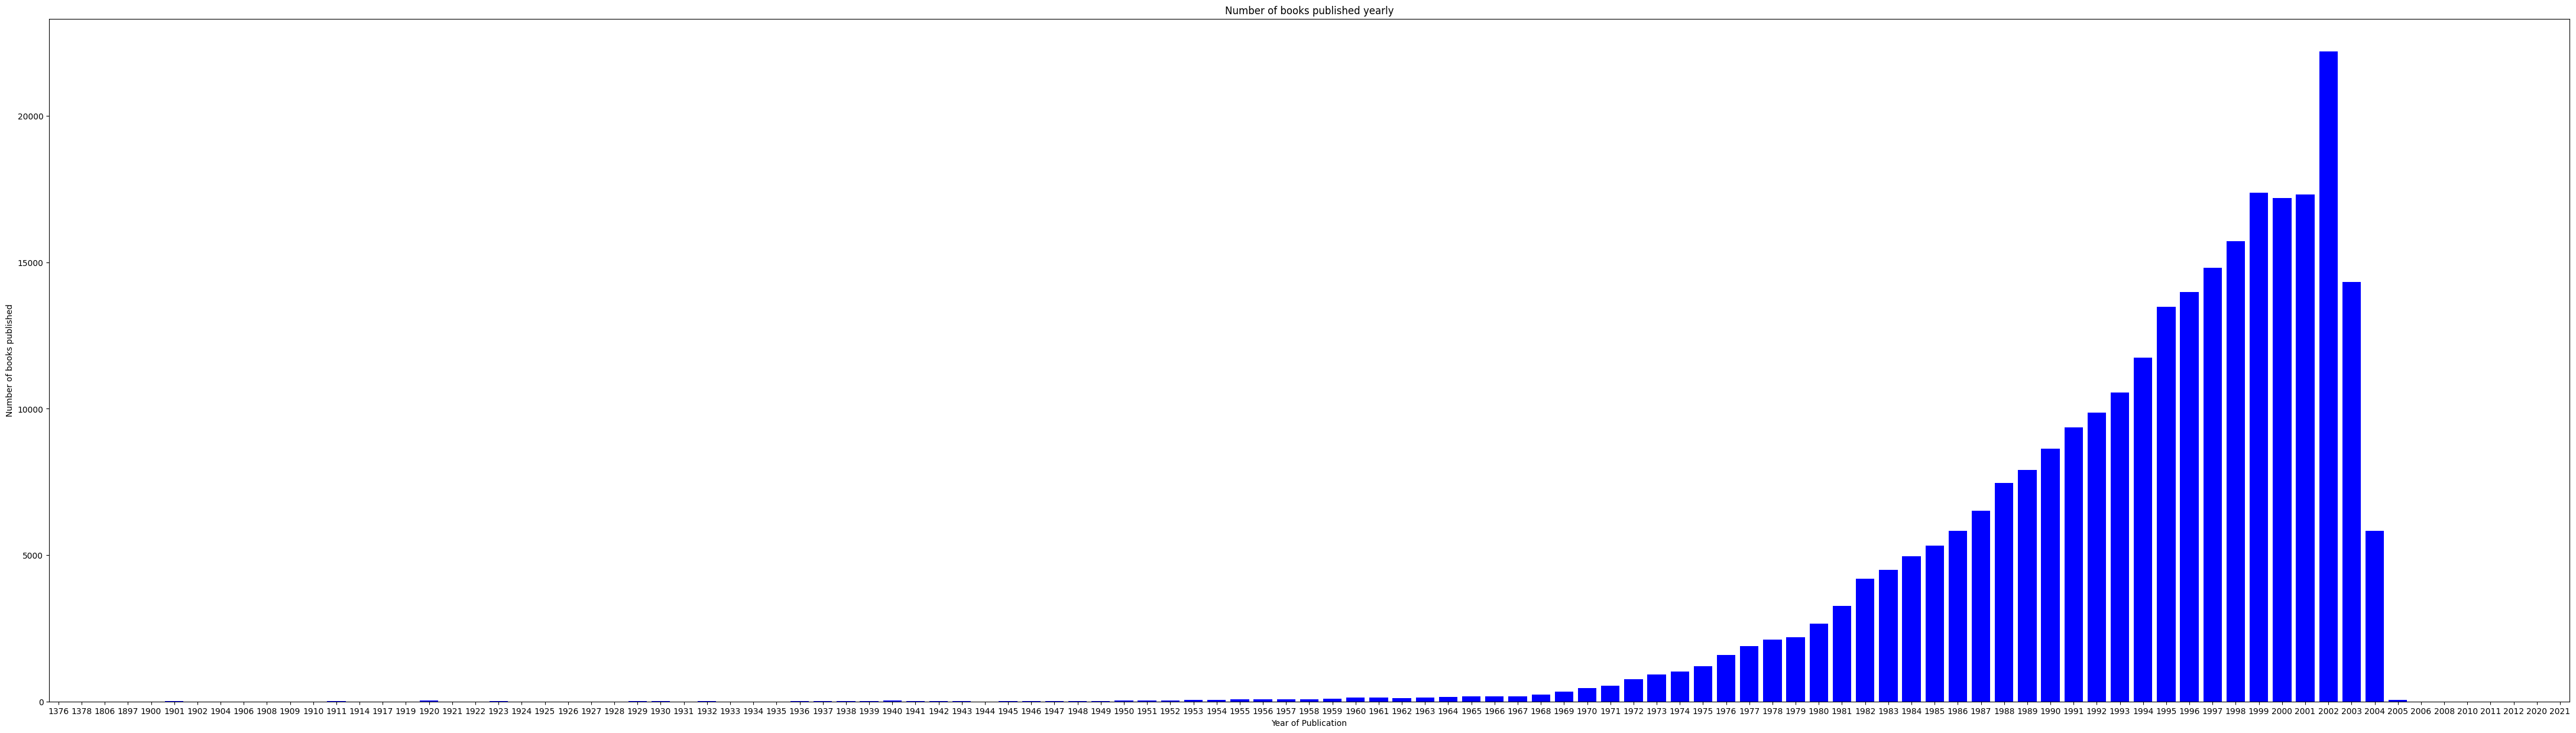

In [ ]:
publications = {}
for year in books['Year-Of-Publication']:
    if str(year) not in publications:
        publications[str(year)] = 0
    publications[str(year)] +=1

publications = {k:v for k, v in sorted(publications.items())}

fig = plt.figure(figsize =(55, 15))
plt.bar(list(publications.keys()),list(publications.values()), color = 'blue')
plt.ylabel("Number of books published")
plt.xlabel("Year of Publication")
plt.title("Number of books published yearly")
plt.margins(x = 0)
plt.show()

Text(0.5, 1.0, 'No of books by an author (Top 15)')

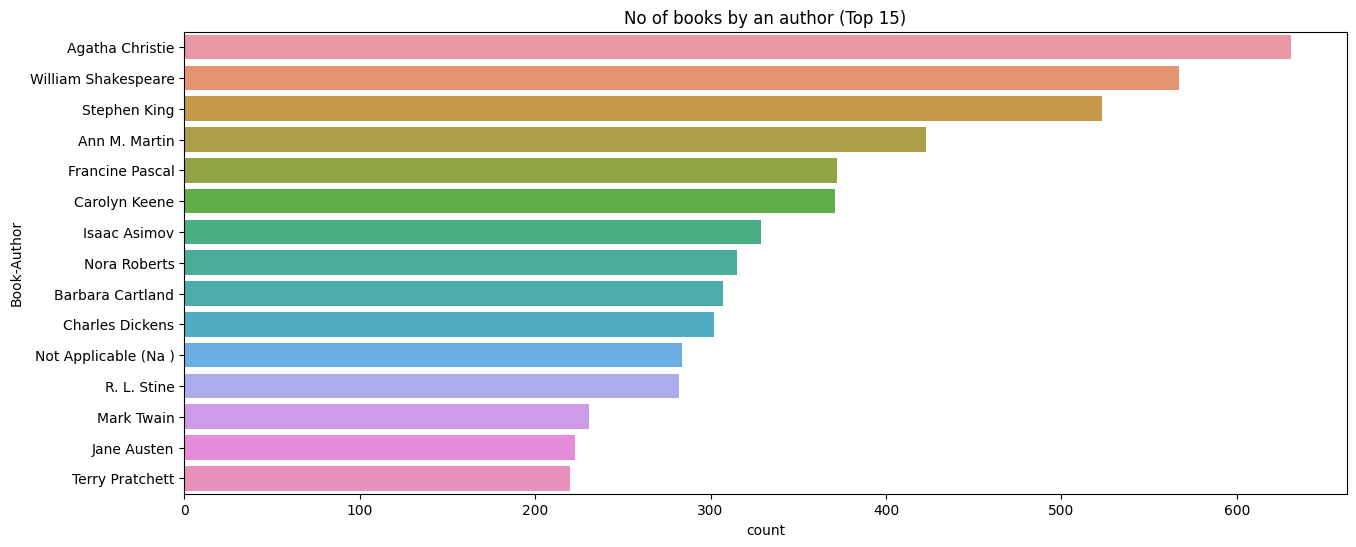

In [ ]:
plt.figure(figsize=(15,6))
sns.countplot(y="Book-Author", data=books,order=books['Book-Author'].value_counts().index[0:15])
plt.title("No of books by an author (Top 15)")

Text(0.5, 1.0, 'No of readers from each country (Top 10)')

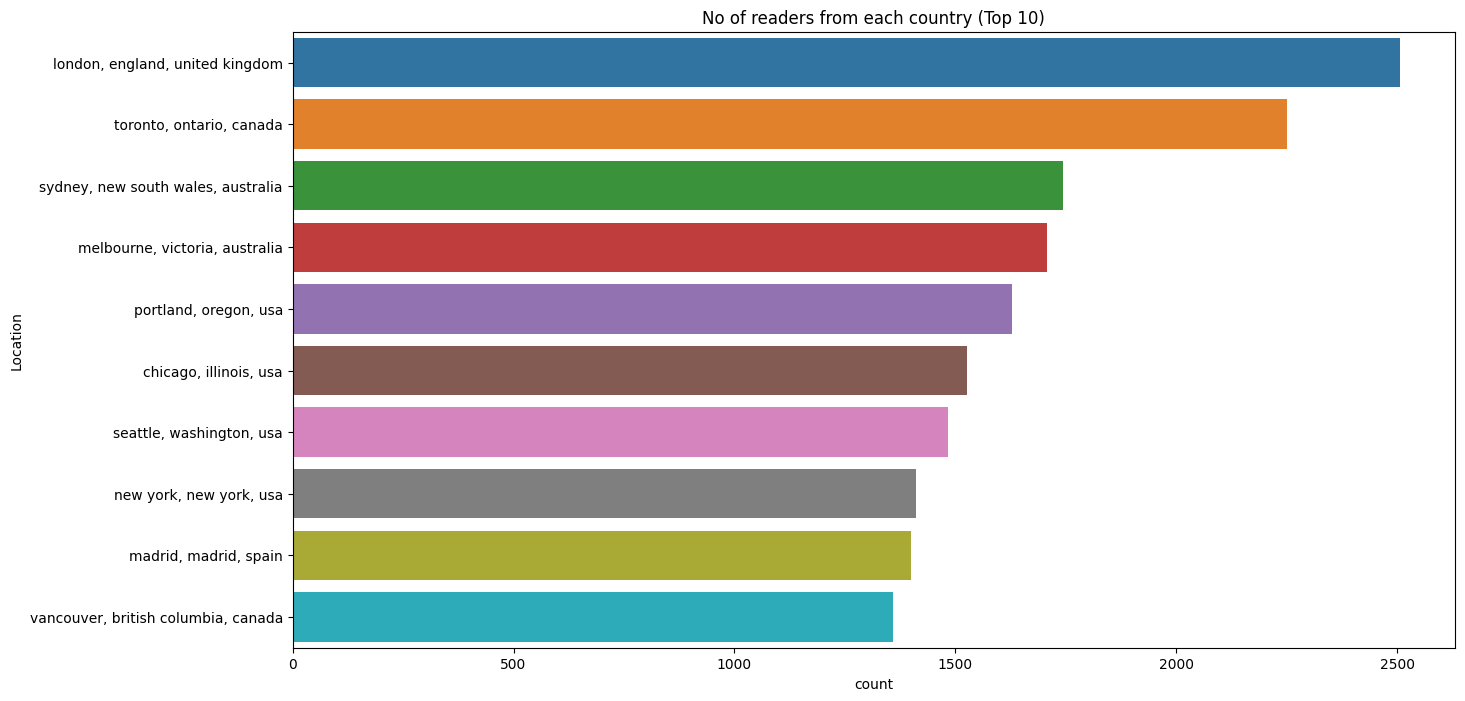

In [ ]:
plt.figure(figsize=(15,8))
sns.countplot(y="Location", data=users, order=users['Location'].value_counts().index[0:10])
plt.title("No of readers from each country (Top 10)")

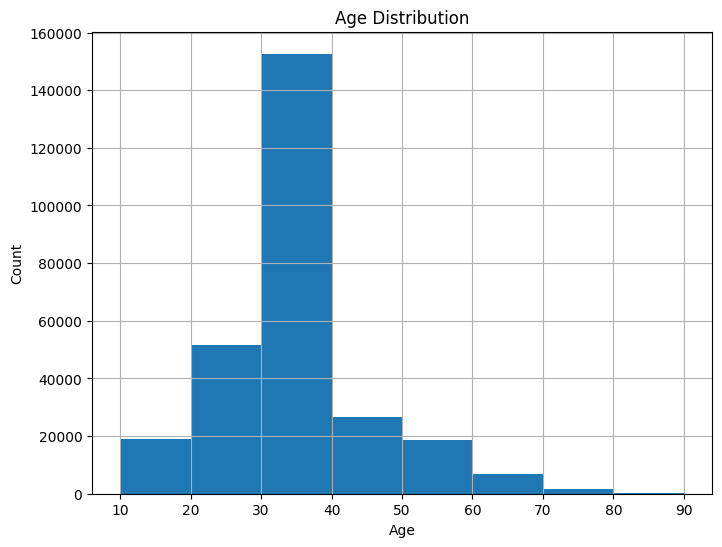

In [ ]:
plt.figure(figsize=(8,6))
users.Age.hist(bins=[10*i for i in range(1, 10)])
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

Text(0.5, 1.0, 'Explicit Ratings')

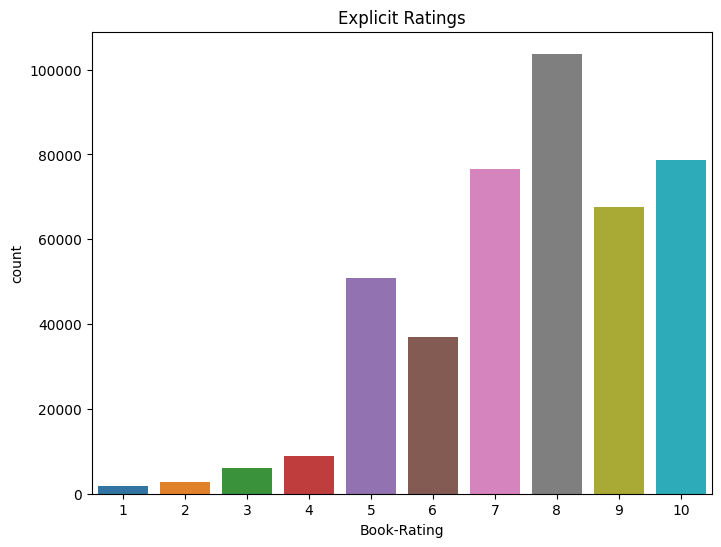

In [ ]:
plt.figure(figsize=(8,6))
data = ratings[ratings['Book-Rating'] != 0]
sns.countplot(x="Book-Rating", data=data)
plt.title("Explicit Ratings")

# **Recommendation Systems**

In [ ]:
#Popularity Based (Top In whole collection)
number = int(input("Enter number of books to recommend: "))
bookName = input("Enter a book name: ")
def popularity_based(dataframe, n):
    if n >= 1 and n <= len(dataframe):
        data = pd.DataFrame(dataframe.groupby('ISBN')['Book-Rating'].count()).sort_values('Book-Rating', ascending=False).head(n)
        result = pd.merge(data, books, on='ISBN')
        return result
    return "Invalid number of books entered!!"
print("Top", number, "Popular books are: ")
popularity_based(dataset1, number)

Enter number of books to recommend: 5
Enter a book name: Wild Animus
Top 5 Popular books are: 


,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0316666343,707,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown"
1,0971880107,581,Wild Animus,Rich Shapero,2004,Too Far
2,0385504209,487,The Da Vinci Code,Dan Brown,2003,Doubleday
3,0312195516,383,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA
4,0060928336,320,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997,Perennial


**Collaborative Filtering (User-Item Filtering)**

Collaborative filtering systems can be extremely accurate and provide effective suggestions, especially when relying on context-aware filtering.These systems can predict customers' interest in a product they didn't know existed by observing what caught the attention of similar users.

Recommendation engines based on this approach perform well even without understanding the nature of each item, which eliminates the need for detailed product descriptions.

In [ ]:
df = pd.DataFrame(dataset1['Book-Title'].value_counts())
df['Total-Ratings'] = df['Book-Title']
df['Book-Title'] = df.index
df.reset_index(level=0, inplace=True)
df = df.drop('index',axis=1)

df = dataset1.merge(df, left_on = 'Book-Title', right_on = 'Book-Title', how = 'left')
df = df.drop(['Year-Of-Publication','Publisher','Age','Location'], axis=1)

popularity_threshold = 50
popular_book = df[df['Total-Ratings'] >= popularity_threshold]
popular_book = popular_book.reset_index(drop = True)

In [ ]:
testdf = pd.DataFrame()
testdf['ISBN'] = popular_book['ISBN']
testdf['Book-Rating'] = popular_book['Book-Rating']
testdf['User-ID'] = popular_book['User-ID']
testdf = testdf[['User-ID','Book-Rating']].groupby(testdf['ISBN'])

In [ ]:
listOfDictonaries=[]
indexMap = {}
reverseIndexMap = {}
ptr=0

for groupKey in testdf.groups.keys():
    tempDict={}
    groupDF = testdf.get_group(groupKey)
    for i in range(0,len(groupDF)):
        tempDict[groupDF.iloc[i,0]] = groupDF.iloc[i,1]
    indexMap[ptr]=groupKey
    reverseIndexMap[groupKey] = ptr
    ptr=ptr+1
    listOfDictonaries.append(tempDict)

dictVectorizer = DictVectorizer(sparse=True)
vector = dictVectorizer.fit_transform(listOfDictonaries)
pairwiseSimilarity = cosine_similarity(vector)

In [ ]:
def printBookDetails(bookID):
    print(dataset1[dataset1['ISBN']==bookID]['Book-Title'].values[0])
    """
    print("Title:", dataset1[dataset1['ISBN']==bookID]['Book-Title'].values[0])
    print("Author:",dataset1[dataset['ISBN']==bookID]['Book-Author'].values[0])
    #print("Printing Book-ID:",bookID)
    print("\n")
    """

def getTopRecommandations(bookID):
    collaborative = []
    row = reverseIndexMap[bookID]
    print("Input Book:")
    printBookDetails(bookID)

    print("\nRecommended Books:")
    mn = 0
    similar = []
    for i in np.argsort(pairwiseSimilarity[row])[:-2][::-1]:
          if dataset1[dataset1['ISBN']==indexMap[i]]['Book-Title'].values[0] not in similar:
                if mn>=number:
                      break
                mn+=1
                similar.append(dataset1[dataset1['ISBN']==indexMap[i]]['Book-Title'].values[0])
                printBookDetails(indexMap[i])
                collaborative.append(dataset1[dataset1['ISBN']==indexMap[i]]['Book-Title'].values[0])
    return collaborative

In [ ]:
k = list(dataset1['Book-Title'])
m = list(dataset1['ISBN'])

collaborative = getTopRecommandations(m[k.index(bookName)])

Input Book:
Wild Animus

RECOMMENDATIONS:

Chicken Soup for the Teenage Soul (Chicken Soup for the Soul)
The Andromeda Strain
Q Is for Quarry
Cause of Death
Snow Falling on Cedars


**kNN**

kNN is a machine learning algorithm to find clusters of similar users based on common book ratings, and make predictions using the average rating of top-k nearest neighbors.

In [ ]:
data = (dataset1.groupby(by = ['Book-Title'])['Book-Rating'].count().reset_index().
        rename(columns = {'Book-Rating': 'Total-Rating'})[['Book-Title', 'Total-Rating']])

result = pd.merge(data, dataset1, on='Book-Title')
result = result[result['Total-Rating'] >= popularity_threshold]
result = result.reset_index(drop = True)

matrix = result.pivot_table(index = 'Book-Title', columns = 'User-ID', values = 'Book-Rating').fillna(0)
up_matrix = csr_matrix(matrix)

In [ ]:
model = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model.fit(up_matrix)

distances, indices = model.kneighbors(matrix.loc[bookName].values.reshape(1, -1), n_neighbors = number+1)
print("\nRecommended books:")
for i in range(0, len(distances.flatten())):
    if i > 0:
        print(matrix.index[indices.flatten()[i]])


Recommended books:
Prodigal Summer
At Home in Mitford (The Mitford Years)
Pay It Forward
Back Roads
Notes from a Small Island


**Content-Based Filtering**

This approach mainly considers the item's characteristics, such as price, category, and other features defined by assigned keywords and tags, along with user preferences interpreted from their purchases and related feedback.

Based on these metrics, a machine learning algorithm (be it Bayesian classifiers, decision trees, clustering, etc.) will investigate customers' purchase patterns and recommend other products sharing similar features with those previously bought and positively reviewed.

In [ ]:
popularity_threshold = 80
popular_book = df[df['Total-Ratings'] >= popularity_threshold]
popular_book = popular_book.reset_index(drop = True)
tf = TfidfVectorizer(ngram_range=(1, 2), min_df = 1, stop_words='english')
tfidf_matrix = tf.fit_transform(popular_book['Book-Title'])
normalized_df = tfidf_matrix.astype(np.float32)
cosine_similarities = cosine_similarity(normalized_df, normalized_df)

In [ ]:
print("Recommended Books:")
isbn = books.loc[books['Book-Title'] == bookName].reset_index(drop = True).iloc[0]['ISBN']
content = []

idx = popular_book.index[popular_book['ISBN'] == isbn].tolist()[0]
similar_indices = cosine_similarities[idx].argsort()[::-1]
similar_items = []
for i in similar_indices:
    if popular_book['Book-Title'][i] != bookName and popular_book['Book-Title'][i] not in similar_items and len(similar_items) < number:
        similar_items.append(popular_book['Book-Title'][i])
        content.append(popular_book['Book-Title'][i])

for book in similar_items:
    print(book)

Recommended Books:
Into the Wild
Hannibal
The Da Vinci Code
Angels & Demons
Hard Eight : A Stephanie Plum Novel (A Stephanie Plum Novel)
